In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

df = pd.read_csv("../data_clean/processed_data_with_features.csv")

#Dropping any rows with missing values
df = df.dropna()

#targets and features
X = df.select_dtypes(include=["number"]).drop(columns=["LOG_RETURN"])
y = df["LOG_RETURN"]

#splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#training 
model = GradientBoostingRegressor(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=3, 
    random_state=42
)
model.fit(X_train, y_train)

#testing
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("R² Score:", r2)


MSE: 2.029284181882594e-06
R² Score: 0.793014140199405


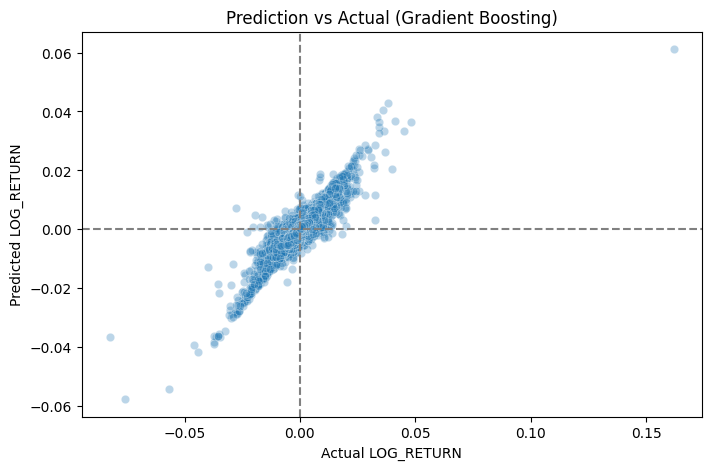

In [9]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.xlabel("Actual LOG_RETURN")
plt.ylabel("Predicted LOG_RETURN")
plt.title("Prediction vs Actual (Gradient Boosting)")
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.show()
